In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Photometrics.PhotometricModules import *

On start-up, download this package from GitHub and add its file location to the Python PATH variable.

In the `FetchMaterials.py` file, give the `datasetsFolder` variable the path location to the directory where the datasets are stored.

## Defining a Sample

A sample is an object used to calculate the X-ray transmission through an arbitrary medium and has the following structure:
> <div class="alert alert-block alert-success"><b>Sample</b>(materialList: List[str], energyRange: Tuple[float, float], densityScaling : List[float] = None, forceDataset: str = 'none')

* `materialList`: A list of elemental components in the material. Standard elemental names are used as well as a few specialty materials. Additional materials can be added by adding a `<Source>_<Material Name>.txt` file relating the photon energy and attenuation lengths, adding the `<Source>` and valid photon energy range to the `sourceList` parameter in the `FetchMaterials.py` module, adding the `<Material Name>` to the `validMaterials` list, and adding any necessary processing steps to the `initializeMaterial` function for the given `<Source>` to give the attenuation length in microns as a function of the photon energy in keV.
* `energyRange`: A range of energies (keV) over which to calculate the transmission.
* `densityScaling`: A list of scalars of the same length as the `materialList` used to modify the density of the material relative to its density at room temperature; for example, for liquid materials.
* `forceDataset` : A string used to force a reference to the CXRO, NIST, or user installed databases for a material. If 'none' is provided, then the database will be chosen for which the material exists and the energy range of the database covers the `energyRange` provided, favoring CXRO if both are valid.

Two primary functions exist:
> <div class="alert alert-block alert-info"><b>.transmission</b>(energy: Union[int, float, np.ndarray], thickness: List[float])

which calculates the sample transmission at a given energy (or for a list of energies), given a specification of the sample thickness in microns for each component of the `materialList` used to define the `Sample` object.

> <div class="alert alert-block alert-info"><b>.convert_weightFraction_to_linearFraction</b>(weightFraction: List[float])

which converts a weight fraction (the usual specification of a material composition) into the linear thicknesses used by the `.tranmission` function, neglecting changes in density upon mixing of alloys.

In [31]:
print(Sample.valid_materials)

['Ag', 'Al', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Ca', 'Cd', 'C-diamond', 'C-glassy', 'Co', 'Cr', 'Cs', 'Cu', 'Fe', 'Ga', 'Ge', 'Hf', 'Hg', 'In', 'Ir', 'K', 'Li', 'Mg', 'Mn', 'Mo', 'Na', 'Nb', 'Ni', 'Os', 'Pb', 'Pd', 'Pt', 'Rb', 'Re', 'Rh', 'Ru', 'Sb', 'Sc', 'Si', 'Sn', 'Sr', 'Ta', 'Tc', 'Ti', 'Tl', 'U', 'V', 'W', 'Y', 'Zn', 'Zr', 'LuAG']


In [35]:
# Density shift due to being in liquid state
# https://periodictable.com/Properties/A/LiquidDensity.al.html
scale_density_Al = 2.375/2.7

energy_range = (10, 400)

aluminum = Sample(['Al', 'Al'], energy_range, [1,scale_density_Al])

Text(0.5, 1.0, 'Tranmission through Solid Aluminum at 10keV')

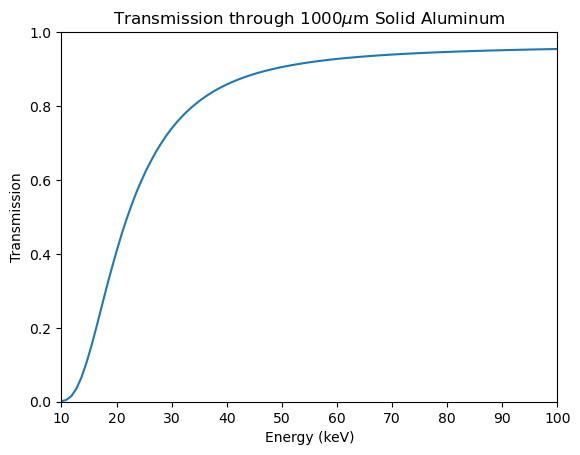

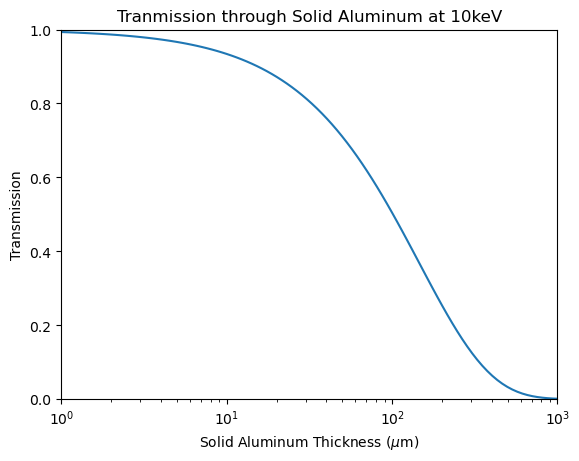

In [59]:
e_list = np.linspace(10, 100, 100)
t_list = np.geomspace(1, 1000, 100)

plt.figure(0)
solid_sample_thickness = 1000 # um
liquid_sample_thickness = 0 # um
plt.plot(e_list, aluminum.transmission(e_list, [solid_sample_thickness,liquid_sample_thickness]))
plt.xlim(10, 100)
plt.ylim(0, 1)
plt.xlabel('Energy (keV)')
plt.ylabel('Transmission')
plt.title('Transmission through 1000$\\mu$m Solid Aluminum')

plt.figure(1)
e_specific = 10
plt.plot(t_list, [aluminum.transmission(e_specific, [t,0]) for t in t_list])
plt.xlim(1, 1000)
plt.ylim(0, 1)
plt.xscale('log')
plt.xlabel('Solid Aluminum Thickness ($\\mu$m)')
plt.ylabel('Transmission')
plt.title('Tranmission through Solid Aluminum at 10keV')

<div class="alert alert-block alert-warning"><b>Note:</b> Because the sample thickness is specified as a list, the transmission function can only be evaluated for one composition at a time. Efforts will be made in coming updates to improve this feature.

In [102]:
Ti64 = Sample(['Ti', 'Al', 'V'], energy_range)

composition_casting = lambda thickness, comp : (np.array(comp)*thickness).tolist()
transmission_casting = lambda e, mat, ls, comp : [sample[mat].transmission(e, composition_casting(li, comp)) for li in ls]

In [71]:
# The linear composition associated with 90wt%Ti, 6wt%Al, 4wt%V
print(Ti64.convert_weightFraction_to_linearFraction([0.9, 0.06, 0.04]))

# The thickness of Ti, Al, and V corresponding to a 500 micron total thickness of the Ti64 alloy
print(composition_casting(500, Ti64.convert_weightFraction_to_linearFraction([0.9, 0.06, 0.04])))

[0.8737864077669903, 0.09708737864077668, 0.02912621359223301]
[436.8932038834952, 48.54368932038834, 14.563106796116505]


Text(0.5, 1.0, 'Transmission through 500$\\mu$m Solid Ti64 Alloy')

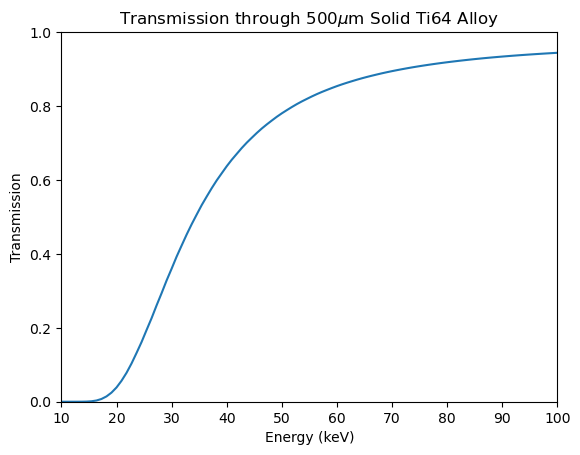

In [81]:
plt.plot(e_list, Ti64.transmission(e_list, composition_casting(500, Ti64.convert_weightFraction_to_linearFraction([0.9, 0.06, 0.04]))))
plt.xlim(10, 100)
plt.ylim(0, 1)
plt.xlabel('Energy (keV)')
plt.ylabel('Transmission')
plt.title('Transmission through 500$\\mu$m Solid Ti64 Alloy')

## Defining a Microscope

A microscope is an object used to calculate the magnification, flux density, etc. of a microscope:
> <div class="alert alert-block alert-success"><b>Microscope</b>(microscopeType : str, definingParameters : Dict[str, Union[int, float, LensMaterial]])

* `microscopeType`: A string specifying 'radiograph' for radiography, 'CRL' for TXM with CRLs, or 'bragg' for magnified holography with Bragg magnifiers.
* `definingParameters`: A dictionary describing the necessary parameters to define the microscope.
  * 'radiograph' :
    * `sample_to_detector` : The sample-to-detector distance.
  * 'CRL' :
    * `material` : `LensMaterial` : The material the CRLs are made of, usually beryllium, diamond, or aluminum.
      * <div class="alert alert-block alert-success"><b>LensMaterial</b>(material: str, thickness: float, energyRange: Tuple[float, float], forceDataset: str = 'none')
      * The `thickness` parameter defines the effective attenuation of the lens and is often fit manually to adjust counts, but otherwise has little significance.
      * This function loads the refractive decriment for valid lens materials.
    * `N` : int : Number of lenslets in the CRL.
    * `radius` : float : Radius of curvature (m) of each lenslet.
    * `aperture` : float : Pinhole aperture diameter (m) placed at the front of the CRL.
    * `lens_thickness` : float : Lenslet-to-lenslet spacing or periodicity (m)
    * `sample_to_detector` : Overall microscope length (m)
    * `sample_to_lens` : float = None : Optional parameter defining the lens position, which overrides the magnification calculation, to give the actual magnification, but not the maximum magnification feasible with the available microscope length.
    * `lens_to_detector` : float = None : Optional parameter defining the lens position, which overrides the magnification calculation, to give the actual magnification, but not the maximum magnification feasible with the available microscope length.
  * 'bragg' :
    * `material` : `LensMaterial` : The material that the single crystals are made of, usually diamond, silicon, or germanium.
    * `cubic_lattice_constant_a` : float : Lattice constant of the lens material (assumed to be cubic) and not provided by the `LensMaterial` specification.
    * `angular_acceptance` : float : Angular acceptance (Darwin width, rad) of the diffraction.
    * `N-bounce` : Union[1, 2, 4] :
      * 1 : 1D angled magnification.
      * 2 : 1D colinear magnification from two crystals assumed to have the same magnification (of the first crystal).
      * 4 : 2D colinear magnification from two orthogonal 2-bounce 1D magnifiers.

The primary functionality of this object for CRLs is to calculate the magnification, focal length, and working distance of the microscope:
> <div class="alert alert-block alert-info"><b>.magnification</b>(energy: Union[int, float, np.ndarray])

which calculates the magnification given the specified microscope length and CRL parameters. Note, when the imaging condition cannot be satisfied, a magnification of $\leq 1$ is reported.

> <div class="alert alert-block alert-info"><b>.fN</b>(energy: Union[int, float, np.ndarray])

which calculates the effective focal length (m) of the CRLs at a given photon energy.

> <div class="alert alert-block alert-info"><b>.sample_to_lens</b>(energy: Union[int, float, np.ndarray])

which calculates the working distance, or sample-to-front of lens distance, in (m).

For the Bragg magnifier case, similar functionality exists to calculate the magnification ignoring the refractive correction and the critical angle of total external reflection that bounds the maximum magnification.

> <div class="alert alert-block alert-info"><b>.magnification</b>(energy: Union[int, float, np.ndarray], hkl : Tuple[int, int, int], miscut : float)

which calculates the magnification as a function of the photon energy, hkl plane of the diffraction, and the miscut angle of the hkl plane used for magnification.

> <div class="alert alert-block alert-info"><b>.theta_c_TER</b>(energy: Union[int, float, np.ndarray])

which calculates the critical angle (rad) of total external reflection based on the photon energy.

### Example: Radiography

In [111]:
microscope_rad = lambda L : Microscope('radiograph', {'sample_to_detector' : L})

### Example: TXM with CRLs

<div class="alert alert-block alert-warning"><b>Note:</b> In this example, we specify the `Microscope` as a lambda functional to generalize the microscope. Now, using the lambda function provides the object for an arbitrary number of lenslets and total microscope length.

In [113]:
microscope_Be = lambda n, L : Microscope('CRL', {'material' : LensMaterial('Be', 5600, (8, 40)),
                                'N' : 50*n, 'radius' : 50e-6, 'aperture' : 300e-6,
                                'lens_thickness' : 2e-3,
                                'sample_to_detector' : L,
                                'sample_to_lens' : None,
                                'lens_to_detector' : None})
microscope_Di1 = lambda n, L : Microscope('CRL', {'material' : LensMaterial('C-diamond', 5600, (8, 40)),
                                'N' : 10*n, 'radius' : 50e-6, 'aperture' : 300e-6,
                                'lens_thickness' : 0.5e-3,
                                'sample_to_detector' : L,
                                'sample_to_lens' : None,
                                'lens_to_detector' : None})
microscope_Di2 = lambda n, L : Microscope('CRL', {'material' : LensMaterial('C-diamond', 5600, (8, 40)),
                                'N' : 20*n, 'radius' : 25e-6, 'aperture' : 140e-6,
                                'lens_thickness' : 0.25e-3,
                                'sample_to_detector' : L,
                                'sample_to_lens' : None,
                                'lens_to_detector' : None})

In [119]:
# Magnification
print(microscope_Be(1, 8.264).magnification(11))
# Effective Focal Length (m)
print(microscope_Be(1, 8.264).fN(11))
# Working Distance (m)
print(microscope_Be(1, 8.264).sample_to_lens(11))

40.23289634105105
0.1431967784231362
0.14806044133578677


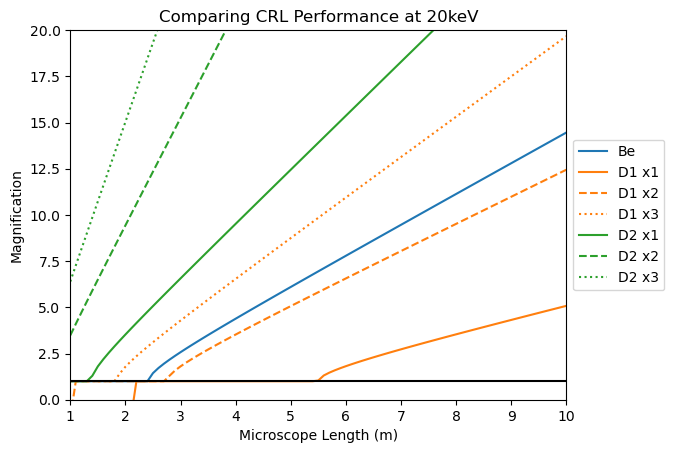

In [131]:
l_list = np.arange(1, 10.1, 0.1)
plt.figure(0)
plt.plot(l_list, [microscope_Be(1, float(l)).magnification(20.0) for l in l_list], label='Be', color='tab:blue', linestyle='solid')
plt.plot(l_list, [microscope_Di1(1, float(l)).magnification(20.0) for l in l_list], label='D1 x1', color='tab:orange', linestyle='solid')
plt.plot(l_list, [microscope_Di1(2, float(l)).magnification(20.0) for l in l_list], label='D1 x2', color='tab:orange', linestyle='dashed')
plt.plot(l_list, [microscope_Di1(3, float(l)).magnification(20.0) for l in l_list], label='D1 x3', color='tab:orange', linestyle='dotted')
plt.plot(l_list, [microscope_Di2(1, float(l)).magnification(20.0) for l in l_list], label='D2 x1', color='tab:green', linestyle='solid')
plt.plot(l_list, [microscope_Di2(2, float(l)).magnification(20.0) for l in l_list], label='D2 x2', color='tab:green', linestyle='dashed')
plt.plot(l_list, [microscope_Di2(3, float(l)).magnification(20.0) for l in l_list], label='D2 x3', color='tab:green', linestyle='dotted')
plt.xlim(1, 10)
plt.ylim(0, 20)
plt.xlabel('Microscope Length (m)')
plt.ylabel('Magnification')
plt.title('Comparing CRL Performance at 20keV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.hlines([1], 1, 10, color='black')

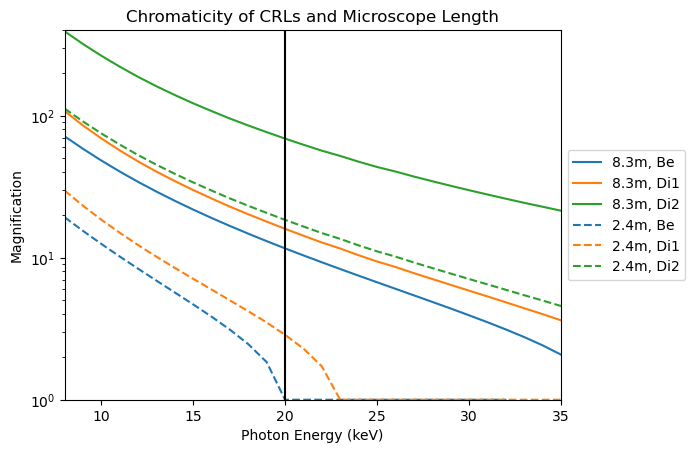

In [133]:
e = np.arange(8, 39, 1)
plt.plot(e, microscope_Be(1, 8.3).magnification(e), label='8.3m, Be', color='tab:blue', linestyle='solid')
plt.plot(e, microscope_Di1(3, 8.3).magnification(e), label='8.3m, Di1', color='tab:orange', linestyle='solid')
plt.plot(e, microscope_Di2(3, 8.3).magnification(e), label='8.3m, Di2', color='tab:green', linestyle='solid')

plt.plot(e, microscope_Be(1, 2.4).magnification(e), label='2.4m, Be', color='tab:blue', linestyle='dashed')
plt.plot(e, microscope_Di1(3, 2.4).magnification(e), label='2.4m, Di1', color='tab:orange', linestyle='dashed')
plt.plot(e, microscope_Di2(3, 2.4).magnification(e), label='2.4m, Di2', color='tab:green', linestyle='dashed')
plt.xlim(8,35)
plt.ylim(1,400)
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Photon Energy (keV)')
plt.ylabel('Magnification')
plt.title('Chromaticity of CRLs and Microscope Length')

plt.vlines([20], 0.01,400, color='black')

<div class="alert alert-block alert-warning"><b>Note:</b> For this plot, we observe the numerical errors that arise when image formation is no longer possible, as the cusp of the dashed blue and orange plots around 20keV, and at the horizontal dashed blue line at still higher energies.

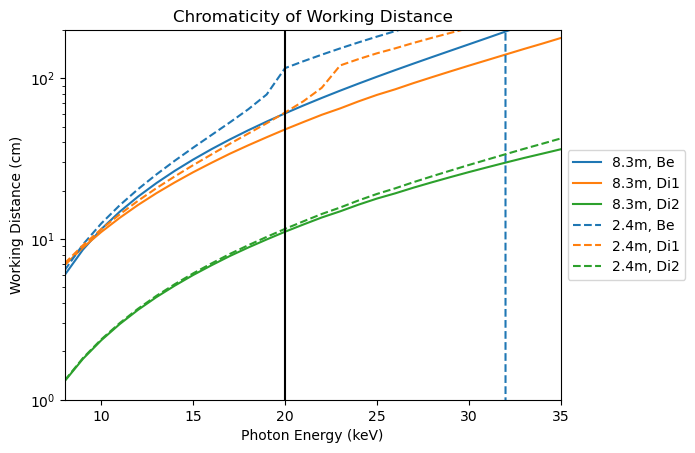

In [135]:
e = np.arange(8, 39, 1)
plt.plot(e, microscope_Be(1, 8.3).sample_to_lens(e)*100, label='8.3m, Be', color='tab:blue', linestyle='solid')
plt.plot(e, microscope_Di1(3, 8.3).sample_to_lens(e)*100, label='8.3m, Di1', color='tab:orange', linestyle='solid')
plt.plot(e, microscope_Di2(3, 8.3).sample_to_lens(e)*100, label='8.3m, Di2', color='tab:green', linestyle='solid')

plt.plot(e, microscope_Be(1, 2.4).sample_to_lens(e)*100, label='2.4m, Be', color='tab:blue', linestyle='dashed')
plt.plot(e, microscope_Di1(3, 2.4).sample_to_lens(e)*100, label='2.4m, Di1', color='tab:orange', linestyle='dashed')
plt.plot(e, microscope_Di2(3, 2.4).sample_to_lens(e)*100, label='2.4m, Di2', color='tab:green', linestyle='dashed')
plt.xlim(8,35)
plt.ylim(1,200)
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Photon Energy (keV)')
plt.ylabel('Working Distance (cm)')
plt.title('Chromaticity of Working Distance')

plt.vlines([20], 1,1200, color='black')

### Example: Bragg Magnifier

In [141]:
microscope_bragg = Microscope('bragg', {'material' : LensMaterial('Si', 10000, (8,40)),
                                'cubic_lattice_constant_a' : 5.3,
                                'angular_acceptance' : lambda dummy : 0.140596, 
                                'N-bounce' : 1})

Text(0, 0.5, 'Magnification 1-bounce')

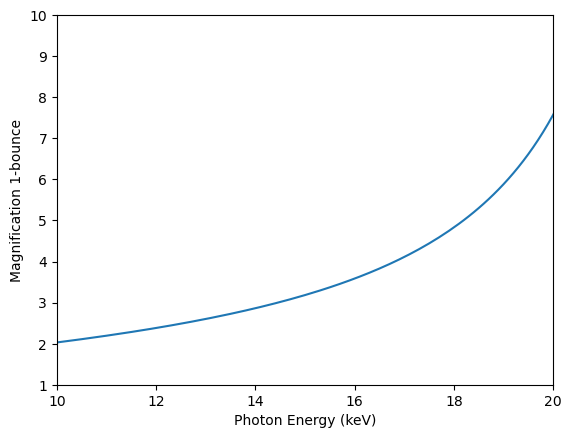

In [171]:
e_range = np.arange(10, 40.1, 0.1)

plt.plot(e_range, microscope_bragg.magnification(e_range, (1,1,1), 5/180*3.14159))
plt.xlim(10, 20)
plt.ylim(1, 10)
plt.xlabel('Photon Energy (keV)')
plt.ylabel('Magnification 1-bounce')

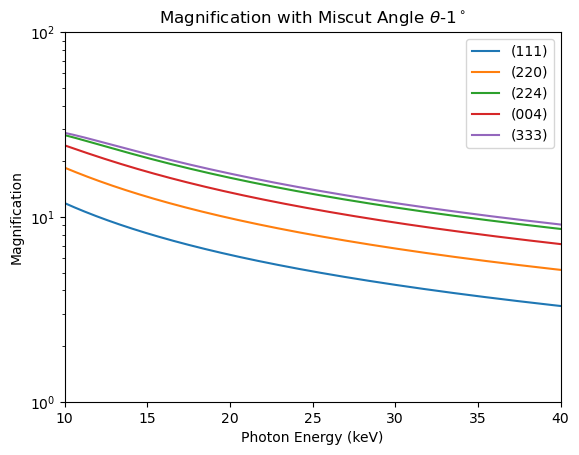

In [165]:
plt.plot(e_range, microscope_bragg.magnification(e_range, (1,1,1), microscope_bragg.theta(e_range, (1,1,1)) - 1/180*np.pi))
plt.plot(e_range, microscope_bragg.magnification(e_range, (2,2,0), microscope_bragg.theta(e_range, (2,2,0)) - 1/180*np.pi))
plt.plot(e_range, microscope_bragg.magnification(e_range, (2,2,4), microscope_bragg.theta(e_range, (2,2,4)) - 1/180*np.pi))
plt.plot(e_range, microscope_bragg.magnification(e_range, (0,0,4), microscope_bragg.theta(e_range, (0,0,4)) - 1/180*np.pi))
plt.plot(e_range, microscope_bragg.magnification(e_range, (3,3,3), microscope_bragg.theta(e_range, (3,3,3)) - 1/180*np.pi))
plt.xlabel('Photon Energy (keV)')
plt.ylabel('Magnification')
plt.title('Magnification with Miscut Angle $\\theta$-1$^\\circ$')
plt.xlim(10, 40)
plt.ylim(1, 100)
plt.yscale('log')
plt.legend(["(111)","(220)","(224)","(004)","(333)"])

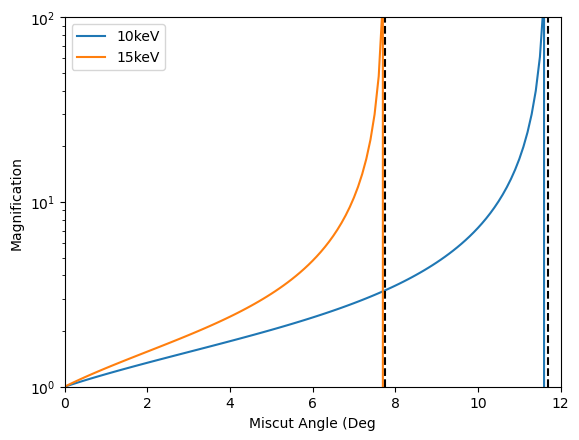

In [169]:
miscut = np.arange(0, 12, 0.1)
plt.plot(miscut, microscope_bragg.magnification(10, (1,1,1), miscut/180*np.pi))
plt.plot(miscut, microscope_bragg.magnification(15, (1,1,1), miscut/180*np.pi))
plt.xlabel('Miscut Angle (Deg')
plt.ylabel('Magnification')
plt.xlim(0,12)
plt.ylim(1,100)
plt.yscale('log')
plt.legend(['10keV', '15keV'])
plt.vlines([microscope_bragg.theta(10, (1,1,1))/np.pi*180, microscope_bragg.theta(15, (1,1,1))/np.pi*180], 1, 100, color='black', linestyle='dashed')

## Defining an X-ray Source

This function is not intended to be used in a stand-alone fashion, but provides the necessary descriptors of the X-ray source for the `Experiment` object to function properly.
> <div class="alert alert-block alert-success"><b>Source</b>(divergence : float, spotSize : Union[float, Tuple[float, float]], spectrum : Union[Tuple[np.ndarray, Tuple[str, None]], Tuple[Callable[[float], float], Tuple[str, None]]], spectrum_pulsed : bool, source_to_sample : float = None, spatialDistribution : np.ndarray = None)

* `divergence`: The divergence (rad) of the source. 0 = collimated; negative is converging and positive is diverging.
* `spotSize`: The spot size of the source at a reference position, either the diameter assuming a circular illumination, or a rectangle with specified height and width (m).
* `spectrum`: The spectrum of the source.
* `spectrum_pulsed`: Boolean defining whether the sample is pulsed, and later used to calculate signal intensities either 'per pulse' or 'per second' (rather, per integration time).
* `source_to_sample`: Defines the distance between where the spot size of the source is reported and the sample to calculate the illuminated spot size and flux density at the sample.
* `spatialDistribution`: Not currently implemented. Intended to be used in an image-simulation version of this code that may one day be updated.


Several convenience functions have been defined to expedite source formulation:
> <div class="alert alert-block alert-info"><b>.fetchSourceSpectrum</b>(filepath : str, scaling : int = 1.0, pad : bool = False, ev : bool = False, threshold : float = 0.0, clip : Tuple[float, float] = None)

Loads an arbitrary spectrum from a `.txt` file which expresses photon energy (first column) vs photons (or photons/s) counts (second column), obtained either from beamline scientists or from plot digitization of published spectra.
* `filepath` : File path to the text-file from which to load.
* `scaling` : The photon count scaling of the second column (i.e., $10^5$).
* `pad` : 0-pads the list to 0keV and 400keV, rarely necessary.
* `ev` : Denotes if the energies in the `.txt` file are given in eV or keV.
* `threshold` : Clips all signals less than `threshold` to 0 due to noise.
* `clip` : Clip a sub-range of photon energies out of the given `.txt` file.

> <div class="alert alert-block alert-info"><b>.monochromaticSpectrum</b>(flux : float, e : float, energy_range : Tuple[float, float] = None)

Creates a Dirac delta function and registry items necessary for downstream functions to properly integrate the spectrum.
* `flux` : The total number of photons (or photons/s) in the Dirac delta function.
* `e` : The energy at which the Dirac delta function is defined.
* `energy_range` : The total energy range of the function used in downstream calculations to confirm energy ranges align.

> <div class="alert alert-block alert-info"><b>.uniformSpectrum</b>(flux : float, a : float, b : float, energy_range : Tuple[float, float] = None)

A spectral square.
* `flux` : The total number of photons (or photons/s) in the Dirac delta function.
* `a` : The lower bound of the spectrum.
* `b` : The upper bound of the spectrum.
* `energy_range` : The total energy range of the function used in downstream calculations to confirm energy ranges align.


Example 1: Defining a source, which loads the ID19 undulator spectrum from a plot digitization, assuming a collimated 2x4mm beam at the sample.

In [184]:
Source(0, (2000, 4000), Source.fetchSourceSpectrum('ESRF_ID19_Undulator_Spectrum.txt', pad=True, threshold=6.03e13, clip=(3,99)), False, source_to_sample = 5)

Example 2: Loading the ID19 wiggle spectrum provided by the beamline scientists' calculation.

In [186]:
Source.fetchSourceSpectrum('ESRF_ID19_W150m_40mm_5.6mmAl_1mmCu.txt', 400, ev=True, pad=True)

(array([[0.0000000e+00, 0.0000000e+00],
        [9.9999900e+00, 0.0000000e+00],
        [1.0000000e+01, 0.0000000e+00],
        ...,
        [3.9941500e+02, 3.1831200e+07],
        [3.9941501e+02, 0.0000000e+00],
        [4.0000000e+02, 0.0000000e+00]]),
 ('Import', 'ESRF_ID19_W150m_40mm_5.6mmAl_1mmCu.txt'))

Example 3: Defining a collimated 0.5x0.5mm square, monochromatic beam as might be found at an XFEL. Because the source is collimated, the `source_to_sample` distance can be arbitrarily assigned.

In [188]:
Source(Source.collimated, (500, 500), Source.monochromaticSpectrum(5e10*0.23, 11), True, source_to_sample = 1)

## Defining a Detector

This function is not intended to be used in a stand-alone fashion, but provides the necessary descriptors of the detectors for the `Experiment` object to function properly.
> <div class="alert alert-block alert-success"><b>Detector</b>(direct : bool, pixelSize : float, pixelCount : Tuple[float, float], pixelEfficiency : Union[float, np.ndarray, Tuple[Sample, List[float]], Callable[[np.ndarray], np.ndarray]], exposureTime : float, scintillator : Scintillator = None, scintillatorSize : float = None, opticalMagnification : float = None, lensFocalLength : float = None, lensNumericalAperture : float = None, scintillator_lens_camera_position : Tuple[float, float] = None)

* `direct`: Specifies whether the detector is a direct X-ray detector or an indirect imaging system using a scintillator. If direct, the scintillator related parameters and optical magnification are not necessary.
* `pixelSize`: Size of pixels in microns, assuming they are square.
* `pixelCount`: Pixel format of the detector, in (H, W).
* `pixelEfficiency`: Quantum efficiency of the detector.
* `exposureTime`: Exposure time of a frame (only used for continuous sources and ignored for pulsed sources which assume one pulse per frame).
* `scintillator`: A Scintillator material object defining the scintillator `material`, its `thickness` in microns and `conversion` efficiency in ph/keV.
> <div class="alert alert-block alert-success"><b>Scintillator</b>(material: str, thickness: float, conversion: Union[float, np.ndarray, Callable[[np.ndarray], np.ndarray]], energyRange: Tuple[float, float])
* `scintillatorSize`: Diameter of the scintillator, which is used to check if the scintillator clips the image size. Often, this is not a concern and the diameter can be set to an arbitrary large value.
* `opticalMagnification`: Magnification of the visible imaging system used to image the scintillator.
* `lensFocalLength`: Optional focal length of the visible imaging system used to image the scintillator. Only used if `opticalMagnification` is not provided.
* `lensNumericalAperture`: Numerical aperture of the visible imaging system used to image the scintillator, which is part of the calculation for the photon efficiency of the indirect imaging system.
* `scintillator_lens_camera_position`: A tuple of the scintillator-to-lens and lens-to-camera distances used to calculate the magnification of the visible imaging system. This term is not used if the `opticalMagnification` is not provided.


Example of an indirect detection system with 6.5$\mu$m pixels in a (2160, 2560) format, 70% quantum efficiency, and 1/53333s exposure time (neglected if the `Source` is `spectrum_pulsed`=True) imaging a 50$\mu$m thick LuAG scintillator with a conversion efficiency of 25 ph/keV through a lens with 0.8$\times$ magnification and a NA$=0.7$ (which in this case is treated as a fitting parameter if not explicitly known).

In [201]:
Detector(False, 6.5, (2160, 2560), 0.7, 1/53333, # QE=0.46
         scintillator = Scintillator('LuAG', 50, 25, (8, 38)),
         scintillatorSize = 100000, # since not optimizing, this just needs to be large enough, assuming it doesn't clip the image
         opticalMagnification = 0.8,
         lensNumericalAperture = 0.7), # NA ~= 1/2/N where N=f-Number

(<Photometrics.PhotometricModules.Detector at 0x251bc3abd40>,)

Example of a direct detection system with 25$\mu$m pixels in a (500, 1000) format with 13.157% quantum efficiency and integration time of 1s.

In [203]:
Detector(True, 25, (500, 1000), 0.13157, 1)

## Defining an Experiment

This object takes in all the necessary information to describe the experimental system and calculates attenuation, photon flux, pixel-limited resolution and magnification and other parameters for every combination of `Sample` and `Detector` specified in the `Experiment`
> <div class="alert alert-block alert-success"><b>Experiment</b>(samples: Dict[str, Sample], microscope: Microscope, detectors: Dict[str, Detector], source: Source)

* `samples`: A dictionary mapping arbitrary sample names to `Sample` objects.
* `microscope`: A singular `Microscope` object defining the microscope type and parameters.
* `detectors`: A dictionary mapping arbitrary detector names to `Detector` objects.
* `source`: A singular `Source` object defining the X-ray source parameters.

Functions:
> <div class="alert alert-block alert-info"><b>.fluxDensity_atSample</b>(energy: Union[int, float, np.ndarray])

Calculates the number of photons/$\mu^2$ per second (or per pulse) at the sample plane as a function of `energy`.

> <div class="alert alert-block alert-info"><b>.fluxDensity_atImage</b>(energy: Union[int, float, np.ndarray])

Calculates the number of photons/$\mu^2$ per second (or per pulse) at the image plane as a function of `energy` if no sample is in the way.

> <div class="alert alert-block alert-info"><b>.fluxDensity_atImage_throughSample</b>(energy: Union[int, float, np.ndarray], thickness: List[float])

Calculates the number of photons/$\mu^2$ per second (or per pulse) at the image plane as a function of `energy` if a sample of the composition specified by `thickness` blocks the beam path.

> <div class="alert alert-block alert-info"><b>.attenuation</b>(energy: Union[int, float, np.ndarray], thickness: List[float])

Attenuation of a sample as a function of `energy` and sample composition specified by `thickness`.

> <div class="alert alert-block alert-info"><b>.spotSize_atSample</b>

A value of the same shape as the input `spotSize` given in the `Source` parameter but using the `divergence` to calculate the spot size at the sample position in microns.

> <div class="alert alert-block alert-info"><b>.spotSize_atImage</b>(energy: Union[int, float, np.ndarray], thickness: List[float])

For a rectangular shape spot size, this function gives a tuple of functions for the x and y instead of a single function.

> <div class="alert alert-block alert-info"><b>.photons_detected_per_pixel</b>

Scalar number of photons (neglecting noise and accounting for quantum efficiency) that would be expected to be read at each pixel. This number times the gain value plus noise would equate to the expected signal on the detector.

> <div class="alert alert-block alert-info"><b>.photons_detected_per_pixel_throughSample</b>(thickness: List[float])

Calculates the number of photons detected per pixel integrated over the entire `Source` spectrum, as a function of the sample composition.

> <div class="alert alert-block alert-info"><b>.photons_detected_per_pixel_perEnergy</b>(energy: Union[int, float, np.ndarray])

Calculates the number of photons detected per pixel at a given energy. This is effectively the `fluxDensity_atImage` function times the pixel area.

> <div class="alert alert-block alert-info"><b>.photons_detected_per_pixel_perEnergy_throughSample</b>(energy: Union[int, float, np.ndarray], thickness: List[float])

Calculates the number of photons detected per pixel through a sample at a given energy as a function of the sample composition. This is effectively the `fluxDensity_atImage_throughSample` function times the pixel area.

> <div class="alert alert-block alert-info"><b>.xray_magnification</b>(energy: Union[int, float, np.ndarray])

A wrapper for the X-ray magnification provided by the `Microscope` object.

> <div class="alert alert-block alert-info"><b>.gauge</b>(energy: Union[int, float, np.ndarray])

The effective pixel size given by the pixel size divided by the total magnification.

> <div class="alert alert-block alert-info"><b>.optical_magnification</b>

The optical magnification specified by the `Detector` object.

> <div class="alert alert-block alert-info"><b>.beam_captured_by_camera</b>(energy: Union[int, float, np.ndarray])

The fraction of the X-ray beam that is captured on the detector (assuming the CRL aperture, if present, does not clip the image).

> <div class="alert alert-block alert-info"><b>.camera_filled_by_beam</b>(energy: Union[int, float, np.ndarray])

The fraction of the detector area that is illuminated by the X-ray beam (assuming the CRL aperture, if present, does not clip the image).

<div class="alert alert-block alert-warning"><b>Note:</b> In general, always keep the energy range the same in the `Sample` and `Detector` objects and slightly larger in the `Microscope` object. If an error is thrown because the energy ranges do not align properly, then play with the energy ranges until the experiment works. In general, larger energy ranges are less problematic. This feature can be finicky and future updates will hopefully address the issue.

### Example: Transmission X-ray Microscope

Specify a 8.264m TXM microscope with a CRL objective using a monochromatic, collimated 0.5$\times$0.5mm$^2$ beam at 11keV with 1.15$\times$10$^{10}$ ph/pulse. This microscope uses one of two detectors a higher resolution Andor Zyla indirect detection scheme and a lower resolution Icarus direct detector to look at aluminum samples in the energy range of 8 - 38keV.

In [3]:
microscope = Microscope('CRL', {'material' : LensMaterial('Be', 5600, (8, 40)),
                                'N' : 50, 'radius' : 50e-6, 'aperture' : 300e-6,
                                'lens_thickness' : 2e-3,
                                'sample_to_detector' : 8.264,
                                'sample_to_lens' : None,
                                'lens_to_detector' : None})

source = Source(Source.collimated, (500, 500), Source.monochromaticSpectrum(5e10*0.23, 11), True, source_to_sample = 1)

sample = {'Al' : Sample(['Al'], (8, 38))}

detector = {'Andor Zyla' : Detector(False, 6.5, (2160, 2560), 0.7, 1/53333,
                                 scintillator = Scintillator('LuAG', 50, 25, (8, 38)),
                                 scintillatorSize = 100000,
                                 opticalMagnification = 0.8,
                                 lensNumericalAperture = 0.7),
            'Icarus' : Detector(True, 25, (500, 1000), 0.13157, 1)}

experiment_TXM = Experiment(sample, microscope, detector, source)

In [49]:
print('Andor Zyla')
for k, v in experiment_TXM.precalculations[('Al', 'Andor Zyla')].items():
    print(k, v)

Andor Zyla
fluxDensity_atSample <function Source.fluxDensity.<locals>.<lambda> at 0x00000228B12BBCE0>
fluxDensity_atImage <function Microscope.fluxDensity_crl.<locals>.<lambda> at 0x00000228B12BB600>
fluxDensity_atImage_throughSample <function Experiment.calculate_fluxDensities.<locals>.<lambda> at 0x00000228B12BBC40>
attenuation <function Sample.__init__.<locals>.<lambda> at 0x00000228B1359940>
spotSize_atSample (500.0, 500.0)
spotSize_atImage (<function Experiment.calculate_fluxDensities.<locals>.<lambda> at 0x00000228B12BBEC0>, <function Experiment.calculate_fluxDensities.<locals>.<lambda> at 0x00000228B12BB920>)
photons_detected_per_pixel 1785.7672461162929
photons_detected_per_pixel_throughSample <function Experiment.calculate_photonCounts.<locals>.<lambda> at 0x00000228B12BB560>
photons_detected_per_pixel_perEnergy <function Experiment.calculate_photonCounts.<locals>.<lambda> at 0x00000228B12BB880>
photons_detected_per_pixel_perEnergy_throughSample <function Experiment.calculate_

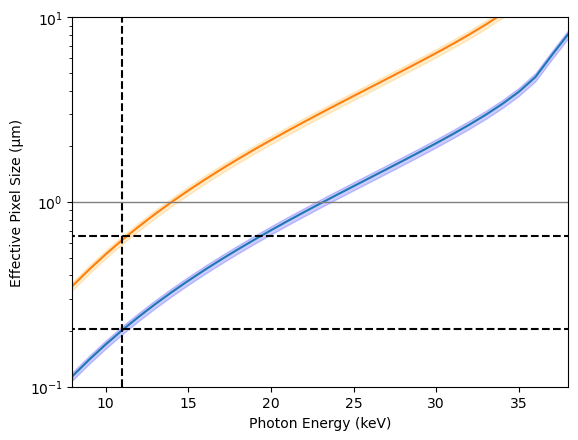

In [5]:
e = np.arange(8, 39, 1)

gauge_Zyla = experiment_TXM.precalculations[('Al', 'Andor Zyla')]['gauge'](e)
gauge_Icarus = experiment_TXM.precalculations[('Al', 'Icarus')]['gauge'](e)
plt.plot(e, gauge_Zyla)
plt.plot(e, gauge_Icarus)
plt.fill_between(e, gauge_Zyla*(1+0.05), gauge_Zyla*(1-0.05), color='blue', alpha=0.2)
plt.fill_between(e, gauge_Icarus*(1+0.05), gauge_Icarus*(1-0.05), color='orange', alpha=0.2)
plt.xlim(8,38)
plt.ylim(0.1,10)
plt.yscale('log')
plt.xlabel('Photon Energy (keV)')
plt.ylabel('Effective Pixel Size (μm)')
#plt.legend(['Zyla','Icarus'])
plt.vlines([11], 0.1, 10, colors='black', linestyles='dashed')
plt.hlines([0.206, 0.657], 5, 40, colors='black', linestyles='dashed')
plt.hlines([1], 5, 40, colors='gray', linewidth=1)

Zyla Gauge:  0.20194916943401298
Icarus Gauge:  0.621382059796963
Zyla Counts:  380.0922387032644
Icarus Counts:  296.7378846862835


Text(0, 0.5, 'Photons Detected Per Pixel Per Pulse')

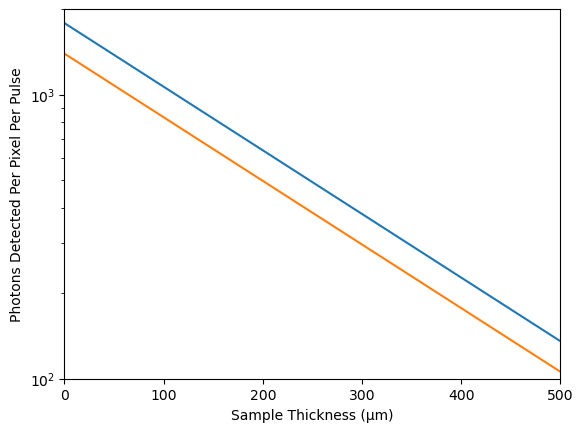

In [7]:
print('Zyla Gauge: ', experiment_TXM.precalculations[('Al', 'Andor Zyla')]['gauge'](11))
print('Icarus Gauge: ', experiment_TXM.precalculations[('Al', 'Icarus')]['gauge'](11))

count_Zyla = lambda t_list : [experiment_TXM.precalculations[('Al', 'Andor Zyla')]['photons_detected_per_pixel_throughSample']([t]) for t in t_list]
count_Icarus = lambda t_list : [experiment_TXM.precalculations[('Al', 'Icarus')]['photons_detected_per_pixel_throughSample']([t]) for t in t_list]
print('Zyla Counts: ', experiment_TXM.precalculations[('Al', 'Andor Zyla')]['photons_detected_per_pixel_throughSample']([300]))
print('Icarus Counts: ', experiment_TXM.precalculations[('Al', 'Icarus')]['photons_detected_per_pixel_throughSample']([300]))
plt.figure(2)
t_list = np.arange(0,501,10)
plt.plot(t_list, count_Zyla(t_list))
plt.plot(t_list, count_Icarus(t_list))
plt.xlim(0,500)
plt.ylim(100,2000) #1, 150
plt.yscale('log')
plt.xlabel('Sample Thickness (μm)')
plt.ylabel('Photons Detected Per Pixel Per Pulse')
#plt.legend(['Zyla', 'Icarus'])

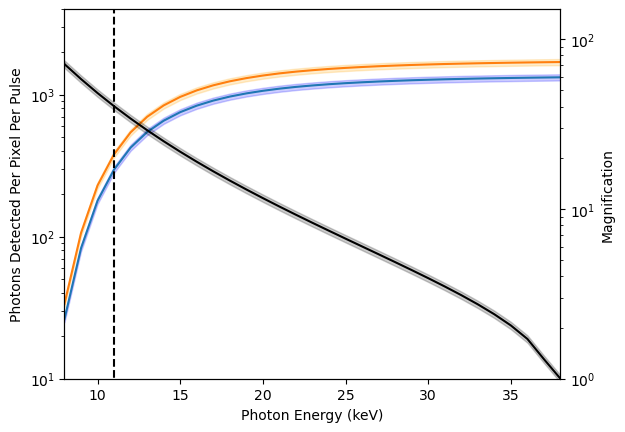

In [9]:
trans_Zyla = lambda e, t : experiment_TXM.precalculations[('Al', 'Icarus')]['photons_detected_per_pixel_perEnergy_throughSample'](11, [t]) / experiment_TXM.precalculations[('Al', 'Icarus')]['attenuation'](11, [t]) * experiment_TXM.precalculations[('Al', 'Icarus')]['attenuation'](e, [t])
trans_Icarus = lambda e, t : experiment_TXM.precalculations[('Al', 'Andor Zyla')]['photons_detected_per_pixel_perEnergy_throughSample'](11, [t]) / experiment_TXM.precalculations[('Al', 'Andor Zyla')]['attenuation'](11, [t]) * experiment_TXM.precalculations[('Al', 'Andor Zyla')]['attenuation'](e, [t])

plt.plot(e, trans_Zyla(e, 300))
plt.plot(e, trans_Icarus(e, 300))
plt.fill_between(e, trans_Zyla(e, 300)*(1+0.05), trans_Zyla(e, 300)*(1-0.05), color='blue', alpha=0.2)
plt.fill_between(e, trans_Icarus(e, 300)*(1+0.05), trans_Icarus(e, 300)*(1-0.05), color='orange', alpha=0.2)
plt.xlim(8,38)
plt.ylim(10,4000) #1, 150
plt.yscale('log')
plt.xlabel('Photon Energy (keV)')
plt.ylabel('Photons Detected Per Pixel Per Pulse')
#plt.legend(['Zyla','Icarus'])
plt.vlines([11], 1,4000,colors='black', linestyles='dashed') #1, 200

plt.twinx()
plt.ylabel('Magnification')
mag = experiment_TXM.precalculations[('Al', 'Andor Zyla')]['xray_magnification'](e)
plt.plot(e, mag, color='black')
plt.fill_between(e, mag*(1+0.05), mag*(1-0.05), color='black', alpha=0.2)
plt.xlim(8,38)
plt.ylim(1,150)
plt.yscale('log')

### Example: Radiography

In [39]:
energy_range = (10, 400)

sample = {'Ta' : Sample(['Ta'], energy_range)}

microscope = Microscope('radiograph', {'sample_to_detector' : 1.5})

detector = {'FastCam SA-Z 2100K' : Detector(False, 20, (512, 1024), 0.46, 1/53333, 
                                 scintillator = Scintillator('LuAG', 250, 25, energy_range),
                                 scintillatorSize = 100000,
                                 opticalMagnification = 5,
                                 lensNumericalAperture = 0.007/1.5)}

source1 = Source(0, (2000, 4000), Source.fetchSourceSpectrum('ESRF_ID19_Undulator_Spectrum.txt', pad=True, threshold=6.03e13, clip=energy_range), False, source_to_sample = 5)
source2 = Source(0, (2000, 4000), Source.fetchSourceSpectrum('ESRF_ID19_W150m_40mm_5.6mmAl_1mmCu.txt', 4e2*1e3, ev=True, pad=True, clip=energy_range), False, source_to_sample = 5)

experiment_rad1 = Experiment(sample, microscope, detector, source1)
experiment_rad2 = Experiment(sample, microscope, detector, source2)

Text(0.5, 1.0, 'ESRF ID19 Undulator Spectrum Transmitted through 100$\\mu$m Tantalum')

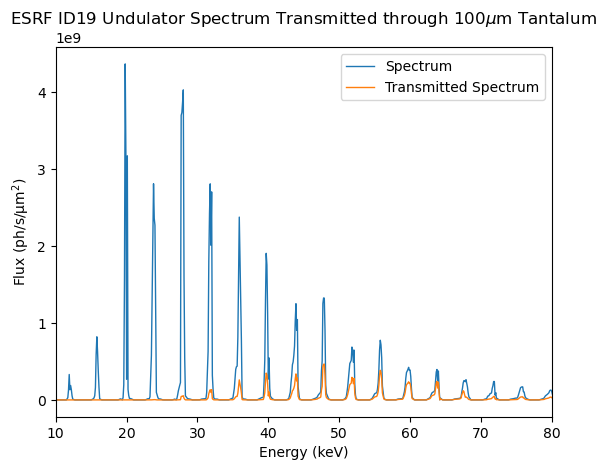

In [41]:
energyBounds = experiment_rad1.energyRanges[('Ta', 'FastCam SA-Z 2100K')]
e_range = np.arange(energyBounds[0], energyBounds[1], 0.1)

plt.plot(e_range, experiment_rad1.precalculations[('Ta', 'FastCam SA-Z 2100K')]['fluxDensity_atImage'](e_range), linewidth=1)
plt.plot(e_range, experiment_rad1.precalculations[('Ta', 'FastCam SA-Z 2100K')]['fluxDensity_atImage_throughSample'](e_range, [100]), linewidth=1)
#plt.legend(['At Sample', 'At Image', 'At Image through Sample'])
plt.legend(['Spectrum', 'Transmitted Spectrum'])
plt.xlim([10,80])
plt.xlabel('Energy (keV)')
plt.ylabel('Flux (ph/s/μm$^2$)')
plt.title('ESRF ID19 Undulator Spectrum Transmitted through 100$\\mu$m Tantalum')

Text(0, 0.5, 'Transmitted Flux Density (ph/s/μm$^2$)')

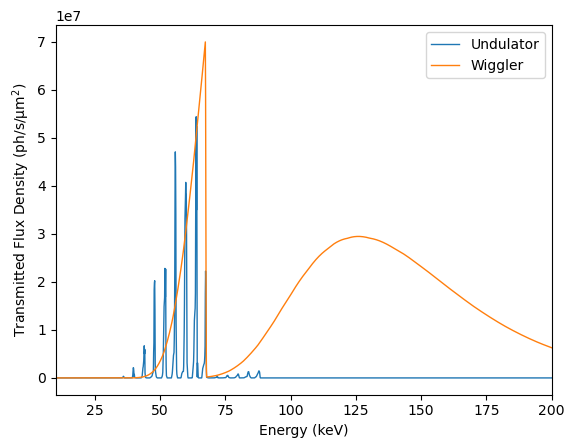

In [43]:
temp_U_trans = experiment_rad1.precalculations[('Ta', 'FastCam SA-Z 2100K')]['fluxDensity_atImage_throughSample'](e_range, [400])
temp_W_trans = experiment_rad2.precalculations[('Ta', 'FastCam SA-Z 2100K')]['fluxDensity_atImage_throughSample'](e_range, [400])
plt.plot(e_range, temp_U_trans, linewidth=1, label='Undulator')
plt.plot(e_range, temp_W_trans, linewidth=1, label='Wiggler')
plt.legend()
plt.xlim([10,200])
plt.xlabel('Energy (keV)')
plt.ylabel('Transmitted Flux Density (ph/s/μm$^2$)')